# Data Visualization Examples for Cancer Risk Analysis

This notebook demonstrates how to visualize cancer incidence data from USCS (U.S. Cancer Statistics).

## Overview

We'll create several visualizations:
1. Pediatric brain tumor incidence patterns
2. Age-specific cancer incidence across lifespan
3. Multi-year comparison of incidence trends


In [32]:
# Import libraries
import sys
from pathlib import Path
import importlib

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Import project modules
from src.data_loader import (
    load_uscs_data,
    prepare_pediatric_brain_data,
    prepare_all_sites_age_data
)

# Force reload visualization modules if updated
if 'src.visualization' in sys.modules:
    importlib.reload(sys.modules['src.visualization'])

from src.utils import age_group_to_mid
from src.visualization import (
    plot_pediatric_brain_distribution,
    plot_pediatric_brain_by_year,
    plot_pediatric_brain_trend,
    plot_age_incidence_curve,
    plot_multi_year_comparison
)

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 11

print("✓ All modules imported successfully!")


✓ All modules imported successfully!


## Data Sources: USCS (current) and TCGA (planned)

These visualizations are currently based on **USCS (U.S. Cancer Statistics)** incidence tables stored in `data/USCS-1999-2022-ASCII/`.

TCGA (The Cancer Genome Atlas) data under `data/TCGA/` is planned for future visualization modules, for example to compare population-level incidence (USCS) with tumor-level genomic features (TCGA) across tissues and ages.


### TCGA DR44 project coverage: visualization-oriented summary

Beyond USCS incidence tables, this project includes a DR44 table of new genomic files and per-project manifests under `data/TCGA/`.
These are useful for **visualizing which cancer types have rich genomic data** and for planning cross-dataset comparisons:

- Compare **population-level incidence curves** (USCS) with **tumor-level genomic coverage** (TCGA) by project.
- Identify tumor types (e.g., `TCGA-LUAD`, `TCGA-COAD`, `TCGA-BRCA`) for which both incidence and genomics are well represented.


Top 10 TCGA projects by number of DR44 data files:


,project_id,n_data_files
26,TCGA-TGCT,1177
2,TCGA-BRCA,1132
1,TCGA-BLCA,822
25,TCGA-STAD,730
27,TCGA-THCA,629
15,TCGA-LUAD,612
29,TCGA-UCEC,591
9,TCGA-HNSC,574
11,TCGA-KIRC,565
13,TCGA-LGG,554


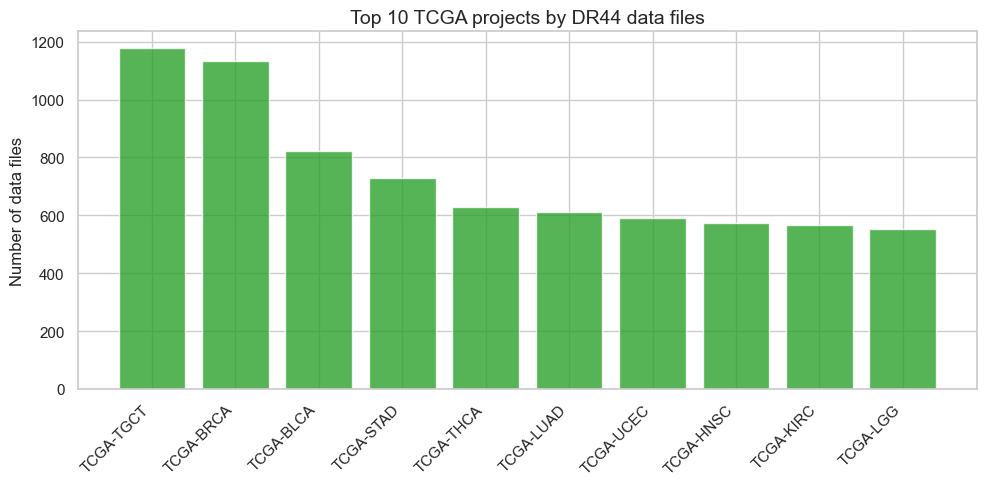

In [33]:
# TCGA DR44 coverage plot: top projects by number of data files
from pathlib import Path

tcga_root = project_root / "data" / "TCGA"
new_files_path = tcga_root / "DR44_new_files_20251029.tsv"

if new_files_path.exists():
    tcga_new_files = pd.read_csv(new_files_path, sep="\t")

    # Filter to TCGA projects and count data files
    tcga_new = tcga_new_files[tcga_new_files["project_id"].str.startswith("TCGA-")].copy()
    tcga_data = tcga_new[tcga_new["category"] == "data_file"].copy()

    tcga_project_counts = (
        tcga_data
        .groupby("project_id")
        .size()
        .reset_index(name="n_data_files")
        .sort_values("n_data_files", ascending=False)
    )

    print("Top 10 TCGA projects by number of DR44 data files:")
    display(tcga_project_counts.head(10))

    # Bar plot of top 10 projects
    top_k = 10
    top_projects = tcga_project_counts.head(top_k)

    plt.figure(figsize=(10, 5))
    plt.bar(top_projects["project_id"], top_projects["n_data_files"], color="tab:green", alpha=0.8)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of data files", fontsize=12)
    plt.title(f"Top {top_k} TCGA projects by DR44 data files", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"TCGA DR44 new-files table not found at: {new_files_path}")
    print("If you want to plot TCGA coverage, ensure DR44_new_files_20251029.tsv exists under data/TCGA/.")


In [34]:
## 1. Load and Prepare Data


In [35]:
# Load data
print("Loading USCS data...")
brain_by_site, by_age = load_uscs_data()

print(f"✓ BRAINBYSITE shape: {brain_by_site.shape}")
print(f"✓ BYAGE shape: {by_age.shape}")

# Prepare data
pediatric_brain = prepare_pediatric_brain_data(brain_by_site)
all_sites_age_inc = prepare_all_sites_age_data(by_age)

print(f"\n✓ Pediatric brain tumor records: {pediatric_brain.shape[0]}")
print(f"✓ Age-specific incidence records: {all_sites_age_inc.shape[0]}")


Loading USCS data...
✓ BRAINBYSITE shape: (8400, 10)
✓ BYAGE shape: (448628, 11)

✓ Pediatric brain tumor records: 1041
✓ Age-specific incidence records: 1350


## 2. Population-level age–incidence (all cancer sites, USCS)

In this section we summarize **population-level cancer risk as a function of age** using USCS data for **all cancer sites combined**.
This provides the global age–incidence pattern that Models A, B, and C aim to explain and refine.



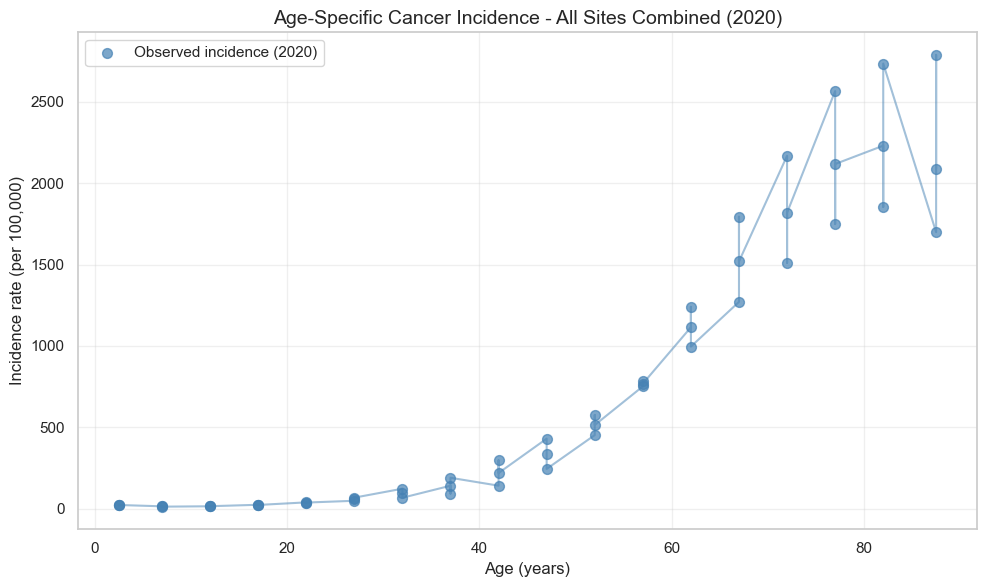


All cancer sites combined (USCS 2020):
  Data points: 54 age groups
  Age range: 2.5–87.5 years
  Incidence range: 11.4–2788.5 per 100,000


In [36]:
# Population-level age–incidence curve (all cancer sites combined)
TARGET_YEAR = 2020

age_model_df = all_sites_age_inc.copy()
age_model_df["AGE_MID"] = age_model_df["AGE"].apply(age_group_to_mid)
age_model_df = age_model_df[age_model_df["AGE_MID"].notna()].copy()

age_year_df = age_model_df[
    pd.to_numeric(age_model_df["YEAR"], errors="coerce") == TARGET_YEAR
].copy()
age_year_df = age_year_df.sort_values("AGE_MID")

ages_all = age_year_df["AGE_MID"].values
rates_all = age_year_df["RATE"].values

# Reuse the helper plotting function from src.visualization
plot_age_incidence_curve(ages_all, rates_all, target_year=TARGET_YEAR)

print(f"\nAll cancer sites combined (USCS {TARGET_YEAR}):")
print(f"  Data points: {len(ages_all)} age groups")
print(f"  Age range: {ages_all.min():.1f}–{ages_all.max():.1f} years")
print(f"  Incidence range: {rates_all.min():.1f}–{rates_all.max():.1f} per 100,000")



## 3. Focused example: colon and rectum incidence vs age (USCS)

To bridge from **global population risk** to a **specific cancer type**, we focus on **colon and rectum cancer**:

- Use USCS BYAGE data to extract age–incidence for the site `Colon and Rectum`.
- This will later be paired with **individual-level colon cancer survival data** from `lifelines` (in `model_c_deterministic_hazard.ipynb`).



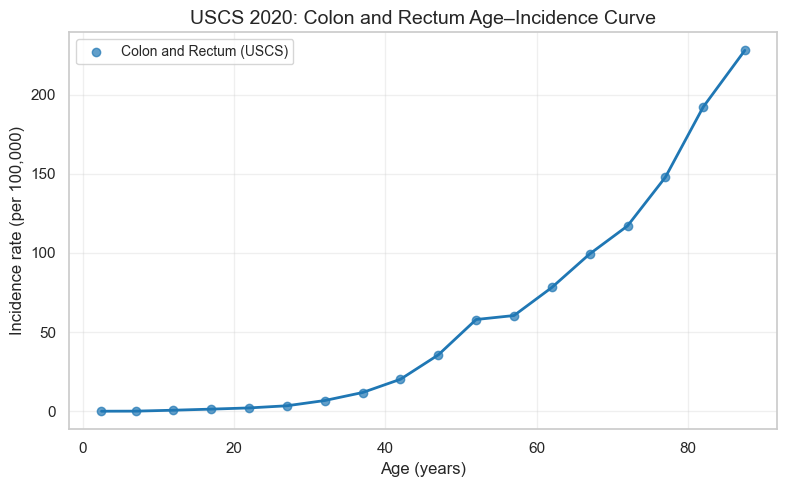

Colon and Rectum (USCS 2020):
  Data points: 18 age groups
  Age range: 2.5–87.5 years
  Incidence range: 0.0–227.9 per 100,000


In [37]:
# USCS age–incidence curve for Colon and Rectum
site_colon = "Colon and Rectum"

# For site-specific curves, BYAGE provides separate rows by sex but not "All Sexes".
# We aggregate over sex by summing COUNT and POPULATION, then recompute RATE.
colon_sex = by_age[
    (by_age["EVENT_TYPE"] == "Incidence")
    & (by_age["RACE"] == "All Races")
    & (by_age["SITE"] == site_colon)
].copy()

for col in ["COUNT", "POPULATION"]:
    colon_sex[col] = pd.to_numeric(colon_sex[col], errors="coerce")

colon_agg = (
    colon_sex
    .groupby(["AGE", "YEAR"], as_index=False)
    .agg({"COUNT": "sum", "POPULATION": "sum"})
)
colon_agg["RATE"] = colon_agg["COUNT"] / colon_agg["POPULATION"] * 100000.0
colon_agg["AGE_MID"] = colon_agg["AGE"].apply(age_group_to_mid)
colon_agg = colon_agg[colon_agg["AGE_MID"].notna()].copy()

colon_year_df = colon_agg[
    pd.to_numeric(colon_agg["YEAR"], errors="coerce") == TARGET_YEAR
].copy()
colon_year_df = colon_year_df.sort_values("AGE_MID")

ages_colon = colon_year_df["AGE_MID"].values
rates_colon = colon_year_df["RATE"].values

plt.figure(figsize=(8, 5))
plt.scatter(ages_colon, rates_colon, color="tab:blue", alpha=0.7, label="Colon and Rectum (USCS)")
plt.plot(ages_colon, rates_colon, color="tab:blue", linewidth=2)
plt.xlabel("Age (years)", fontsize=12)
plt.ylabel("Incidence rate (per 100,000)", fontsize=12)
plt.title(f"USCS {TARGET_YEAR}: Colon and Rectum Age–Incidence Curve", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print(f"Colon and Rectum (USCS {TARGET_YEAR}):")
print(f"  Data points: {len(ages_colon)} age groups")
print(f"  Age range: {ages_colon.min():.1f}–{ages_colon.max():.1f} years")
print(f"  Incidence range: {rates_colon.min():.1f}–{rates_colon.max():.1f} per 100,000")



## 4. Individual-level survival example: colon cancer (lifelines)

To complement the **population-level incidence** view, we briefly summarize
**individual-level colon cancer survival** using the `lifelines` example dataset `data/lifelines/colon.csv`.

This mirrors the analysis in `model_c_deterministic_hazard.ipynb` and makes the
connection between **age**, **incidence**, and **post-diagnosis survival/lethality** explicit.



Loaded colon cancer survival dataset from: D:\资料\graduate\202509\INTRO-GENOMIC INFO SCI & TECH\FinalProject\data\lifelines\colon.csv
Rows: 1858, Columns: 17
Columns: ['Unnamed: 0', 'id', 'study', 'rx', 'sex', 'age', 'obstruct', 'perfor', 'adhere', 'nodes', 'status', 'differ', 'extent', 'surg', 'node4', 'time', 'etype']

Age-group summary (colon cancer dataset):


C:\Users\35769\AppData\Local\Temp\ipykernel_26976\1962666782.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("age_group")


,age_group,n,event_rate,median_time
0,30-49,366,0.530055,1597.5
1,50-59,496,0.455645,2032.0
2,60-69,606,0.523102,1663.5
3,70-84,362,0.464088,1875.0


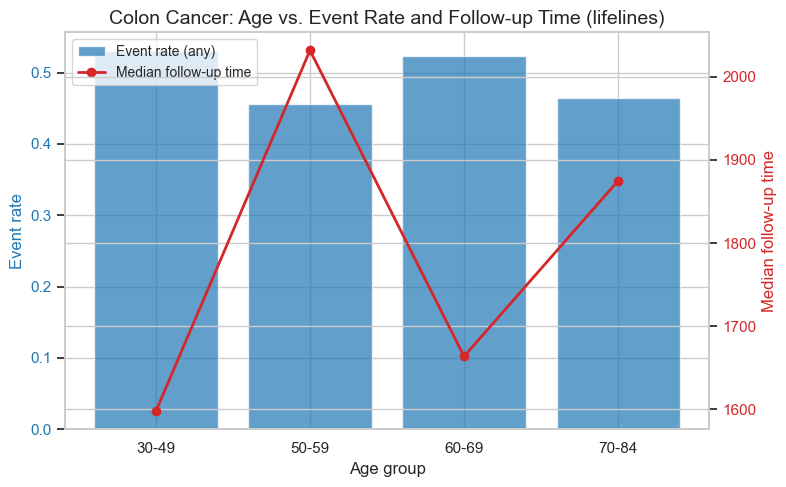

In [38]:
# Age vs. event rate and follow-up time in the colon cancer dataset
colon_path = project_root / "data" / "lifelines" / "colon.csv"

if colon_path.exists():
    colon_df = pd.read_csv(colon_path)
    print(f"Loaded colon cancer survival dataset from: {colon_path}")
    print(f"Rows: {colon_df.shape[0]}, Columns: {colon_df.shape[1]}")
    print("Columns:", list(colon_df.columns))

    # Define a simple event indicator (any non-zero status)
    colon_df["event_any"] = (colon_df["status"] != 0).astype(int)

    # Age bands
    age_bins = [30, 50, 60, 70, 85]
    age_labels = ["30-49", "50-59", "60-69", "70-84"]
    colon_df["age_group"] = pd.cut(colon_df["age"], bins=age_bins, labels=age_labels, right=True)

    age_summary = (
        colon_df
        .groupby("age_group")
        .agg(
            n=("id", "count"),
            event_rate=("event_any", "mean"),
            median_time=("time", "median")
        )
        .reset_index()
    )

    print("\nAge-group summary (colon cancer dataset):")
    display(age_summary)

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Event rate by age group (left axis)
    ax1.bar(age_summary["age_group"], age_summary["event_rate"],
            color="tab:blue", alpha=0.7, label="Event rate (any)")
    ax1.set_xlabel("Age group", fontsize=12)
    ax1.set_ylabel("Event rate", color="tab:blue", fontsize=12)
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Median follow-up time by age group (right axis)
    ax2 = ax1.twinx()
    ax2.plot(age_summary["age_group"], age_summary["median_time"],
             color="tab:red", marker="o", linewidth=2,
             label="Median follow-up time")
    ax2.set_ylabel("Median follow-up time", color="tab:red", fontsize=12)
    ax2.tick_params(axis="y", labelcolor="tab:red")

    plt.title("Colon Cancer: Age vs. Event Rate and Follow-up Time (lifelines)", fontsize=14)

    # Combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper left", fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print(f"colon.csv not found at: {colon_path}")
    print("Ensure data/lifelines/colon.csv exists if you wish to run this example.")



## 5. Summary: three scales for colon cancer (population, individual, genomics)

In this notebook we now have, for colon and rectum cancer:

1. **Population-level incidence** from USCS (age–incidence curves).
2. **Individual-level survival** from the lifelines colon dataset
   (age-stratified event rates and follow-up times).
3. **Project-level genomic coverage** from TCGA DR44 (top TCGA projects by
   number of data files in `data/TCGA/DR44_new_files_20251029.tsv`).

The other notebooks build on this by:

- Fitting mechanistic mutation-accumulation models (Model A).
- Exploring LSCD-based cross-tissue patterns (Model B).
- Fitting hazard-based models and linking to lifelines/TCGA (Model C).



In [39]:
## 2. Pediatric Brain Tumor Incidence Patterns
# Visualize pediatric brain tumor incidence data across different sites and years.


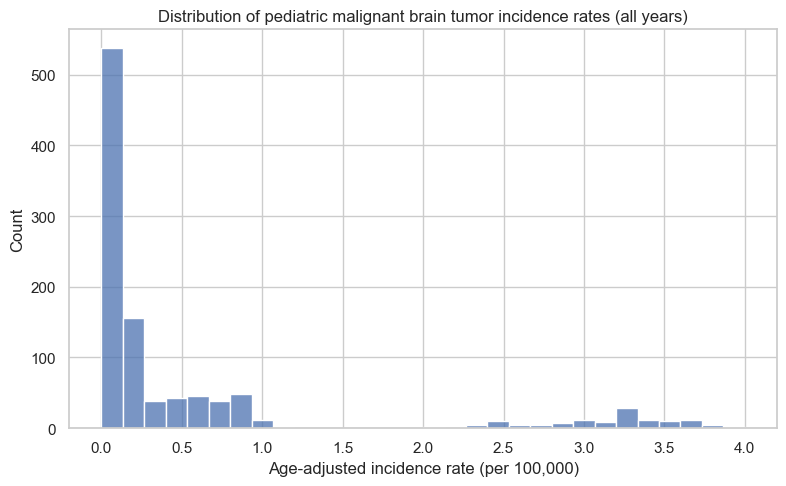

In [40]:
# Figure 1: Distribution of incidence rates
plt.figure(figsize=(8, 5))
plot_pediatric_brain_distribution(pediatric_brain)


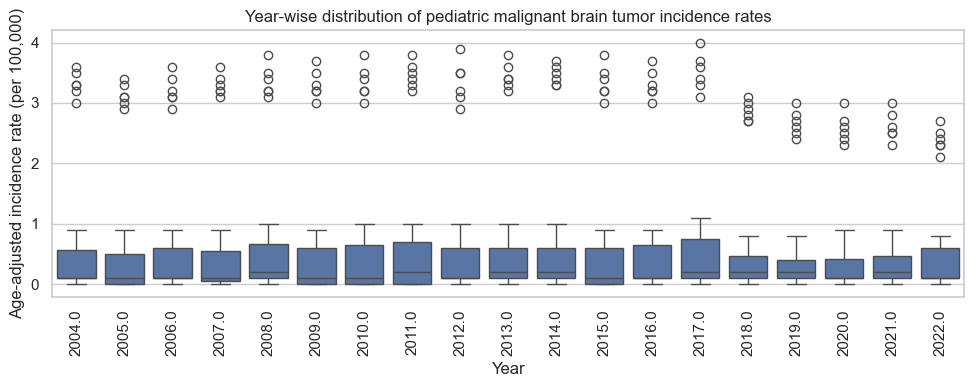

In [41]:
# Figure 2: Year-wise distribution (boxplot)
plot_pediatric_brain_by_year(pediatric_brain)


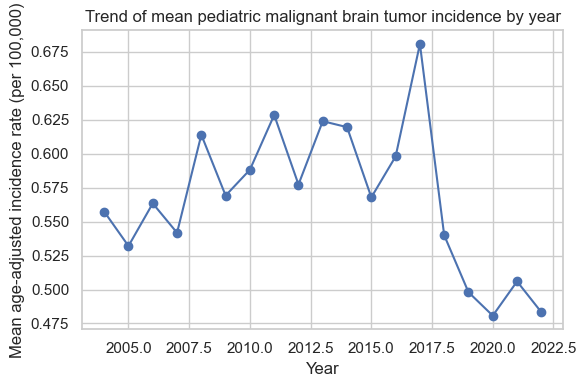

In [42]:
# Figure 3: Trend over time
plot_pediatric_brain_trend(pediatric_brain)


## 3. Age-Specific Cancer Incidence Across Lifespan

Visualize how cancer incidence changes with age for all cancer sites combined.


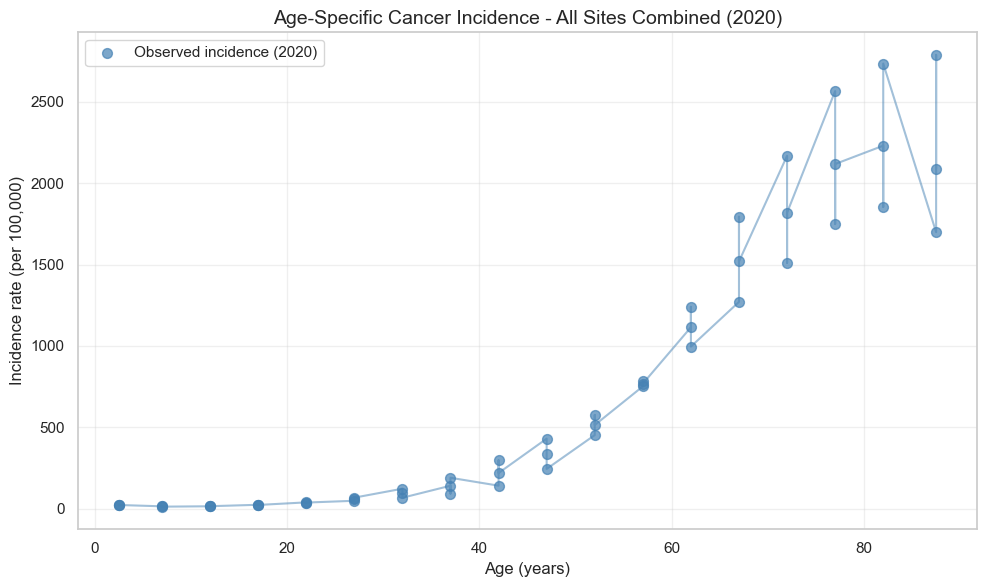

✓ Data points: 54 age groups
✓ Age range: 2.5 - 87.5 years
✓ Incidence range: 11.4 - 2788.5 per 100,000


In [43]:
# Prepare age-incidence data for 2020
TARGET_YEAR = 2020

# Filter for target year
age_model_df = all_sites_age_inc.copy()
age_model_df["AGE_MID"] = age_model_df["AGE"].apply(age_group_to_mid)
age_model_df = age_model_df[age_model_df["AGE_MID"].notna()].copy()

age_year_df = age_model_df[
    pd.to_numeric(age_model_df["YEAR"], errors="coerce") == TARGET_YEAR
].copy()
age_year_df = age_year_df.sort_values("AGE_MID")

# Get ages and rates
ages = age_year_df["AGE_MID"].values
rates = age_year_df["RATE"].values

# Create visualization using the helper function
plot_age_incidence_curve(ages, rates, target_year=TARGET_YEAR)

print(f"✓ Data points: {len(ages)} age groups")
print(f"✓ Age range: {ages.min():.1f} - {ages.max():.1f} years")
print(f"✓ Incidence range: {rates.min():.1f} - {rates.max():.1f} per 100,000")


## 4. Multi-Year Comparison

Compare age-incidence curves across different years to observe temporal trends.
